In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np

In [3]:
project_id = ''

## Data
All data is taken from the [Seattle Real Time Fire 911 Calls](https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkqj) website.

The data was exported as a .csv file, and then imported into a Google Cloud BigQuery instance. The schema of which is described in the table below:

| Field name      | Type   |
|-----------------|--------|
| Address         | STRING |
| Type            | STRING |
| Datetime        | STRING |
| Latitude        | FLOAT  |
| Longitude       | FLOAT  |
| Report_Location | STRING |
| Incident_Number | STRING |

It was noticed that the `Datetime` field had a strange format, so this was processed and split into two separate fields, `report_date` and `report_time`. Thus, the ultimate schema after this ETL process was:

| Field name      | Type   |
|-----------------|--------|
| Address         | STRING |
| Type            | STRING |
| Latitude        | FLOAT  |
| Longitude       | FLOAT  |
| Incident_Number | STRING |
| report_date     | DATE   |
| report_time     | STRING |

As mentioned, Google BigQuery was used to store and query the data.

In [4]:
# Read training data

%%bigquery --project project-id df_t
SELECT 
  EXTRACT(YEAR FROM report_date) AS year
  ,EXTRACT(MONTH FROM report_date) AS month
  ,EXTRACT(DAY FROM report_date) AS day
  ,CAST(SUBSTR(report_time, 0, 2) AS INT) AS hour
  ,Longitude
  ,Latitude
FROM `project-id.seattle_calls.calls-processed`
WHERE EXTRACT(YEAR FROM report_date) BETWEEN 2009 AND 2021;

In [5]:
# Read validation data

%%bigquery --project project-id df_val
SELECT 
  EXTRACT(YEAR FROM report_date) AS year
  ,EXTRACT(MONTH FROM report_date) AS month
  ,EXTRACT(DAY FROM report_date) AS day
  ,CAST(SUBSTR(report_time, 0, 2) AS INT) AS hour
  ,Longitude
  ,Latitude
FROM `project-id.seattle_calls.calls-processed`
WHERE EXTRACT(YEAR FROM report_date) > 2021;

In [6]:
print('Number of training samples: {}'.format(df_t.shape[0]))
print('Number of validation samples: {}'.format(df_val.shape[0]))

Number of training samples: 1214573
Number of validation samples: 84120


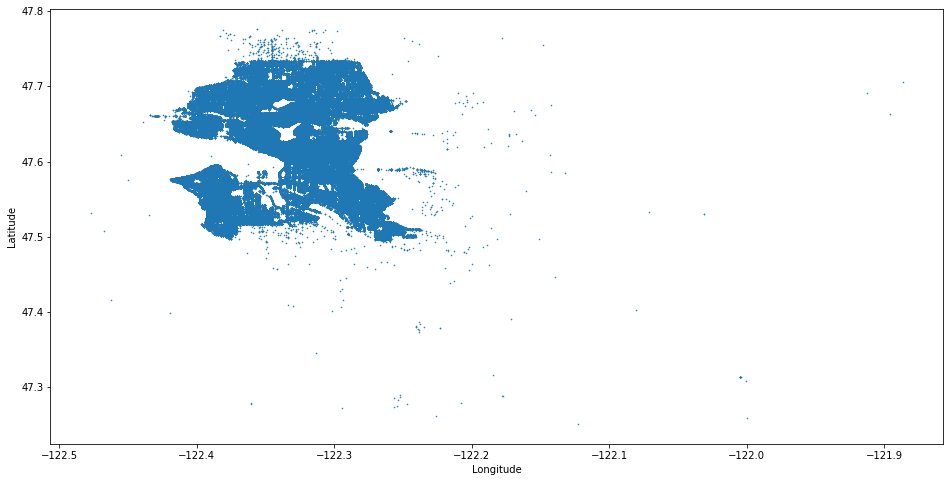

In [8]:
plt.figure(figsize=(16, 8))
plt.scatter(df_t['Longitude'], df_t['Latitude'], s=0.3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Methods

I wanted to capture some notion of geography within the model. To do this, I first attempted to use an API to query the post code using the latitude and longitude. This, however, would have taken too long. For the full dataset, it would have taken approximately 4155 minutes. 

In [ ]:
def return_zipcode(df, geo, latitude, longitude):
  loc = geo.reverse((df[latitude], df[longitude]))
  if loc.raw['address']['postcode']:
    return loc.raw['address']['postcode']
  else:
    return 'Not_Found'


In [ ]:
import time

geolocator = geopy.Nominatim(user_agent='my-application')

n_samples = 20
df_mini = df_train[:n_samples]

start = time.time()

zipcodes = df_mini.apply(return_zipcode, axis=1, geo=geolocator, latitude='Latitude', longitude='Longitude')
end = time.time() - start
print('Total time taken: {}s'.format(end))
print('Estimated time for full df: {} minutes'.format(df_train.shape[0] / n_samples * end / 60))

Total time taken: 9.845580101013184s
Estimated time for full df: 4155.491174634298 minutes


# Clustering

Instead, I decided to use K-Means clustering on the latitude and longitude to create geographical clusters. 

In [9]:
def prepare_data(df_, clusters, include_hour=False):
  df = df_.copy()
  df.loc[:, 'Cluster'] = clusters

  df.drop(['Longitude'], axis=1, inplace=True)
  df.rename({'Latitude': 'Incident_Number'}, axis=1, inplace=True)

  if include_hour:
    df_agg = df.groupby(['Cluster', 'year', 'month', 'day', 'hour']).count().reset_index()
    X = df_agg[['Cluster', 'month', 'year', 'day', 'hour']]
    y = df_agg[['Incident_Number']].values.reshape((-1,))
  else:
    df_agg = df.groupby(['Cluster', 'year', 'month', 'day']).count().reset_index()
    X = df_agg[['Cluster', 'month', 'year', 'day']]
    y = df_agg[['Incident_Number']].values.reshape((-1,))

  return X, y

In [10]:
class ReturnCluster(BaseEstimator, TransformerMixin):
    def __init__(self, clusters=5): 
        self.clusters = clusters
           
    def fit(self, X):
        self.X=X
        self.model = KMeans(n_clusters = self.clusters, n_init=10, max_iter=300, random_state=42)
        self.model.fit(self.X)
        return self
       
    def transform(self, X):
        self.X=X
        X_ = X.copy() # avoiding modification of the original df
        return self.model.predict(X_)



In [11]:
df_t_ = df_t.copy()
df_train = df_t_[df_t_['year'] != 2021]
df_test = df_t_[df_t_['year'] == 2021]

In [12]:
cluster_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('cluster', ReturnCluster(clusters=6))
])

train_clusters = cluster_pipeline.fit_transform(df_train[['Longitude', 'Latitude']])
test_clusters = cluster_pipeline.transform(df_test[['Longitude', 'Latitude']])
val_clusters = cluster_pipeline.transform(df_val[['Longitude', 'Latitude']])

X_train, y_train = prepare_data(df_train, train_clusters, True)
X_test, y_test = prepare_data(df_test, test_clusters, True)
X_val, y_val = prepare_data(df_val, val_clusters, True)

# Fit Regressor

I decided to use gradient boosting, as suggested in the assignment document. To be honest, I did not put a huge amount of effort into testing out different regression methods, due to the time constraints of the project. I did attempt some grid search CV, however I think due to the nature of the data (being time series) it would not provide parameters that actually give good results. 

As can be seen in the cell below, the R2 value when the hour parameter is included came out at 50.7, 47.9 and 48.9 for the training, testing and validation set respectively. This is quite encouraging performance, and shows the model is not likely to overfit. 

When the hour column is not included in the training, then the following results are achieved (excerpt from console print out when I trained using the pipeline):

```
Training started
Training R2: 0.95
Time taken: 4.04s
Training completed

Testing started
Inference R2: 0.83
Time taken: 0.03s
Testing completed

Validation started
Inference R2: 0.81
Time taken: 0.03s
Validation completed
```

Again, encouraging results here, since the model is not likely to overfit. 

In [13]:
import time
"""
start = time.time()
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
print('Training R2: {}'.format(reg.score(X_train, y_train)))
print('Test R2: {}'.format(reg.score(X_test, y_test)))
print('Validation R2: {}'.format(reg.score(X_val, y_val)))
print('Fit time for GradientBoostingRegressor: {}'.format(time.time()-start))
"""
start = time.time()
reg = HistGradientBoostingRegressor()
reg.fit(X_train, y_train)
print('Training R2: {}'.format(reg.score(X_train, y_train)))
print('Test R2: {}'.format(reg.score(X_test, y_test)))
print('Validation R2: {}'.format(reg.score(X_val, y_val)))
print('Fit time for HistGradientBoostingRegressor: {}'.format(time.time()-start))

Training R2: 0.5078264299604203
Test R2: 0.47888190745261106
Validation R2: 0.4898367670544731
Fit time for HistGradientBoostingRegressor: 6.807720422744751


# Backtesting plot for one week

As can be seen, the forecasting appears to follow the trend in the data quite well

Obviously it cannot predict the absolute number of calls that are expected to occur on a given day due to the highly volatile nature of the data, however capture the trend alone is good enough for forecasting employee numbers in my opinion.

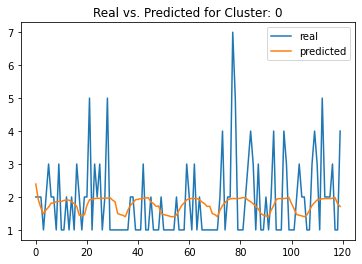

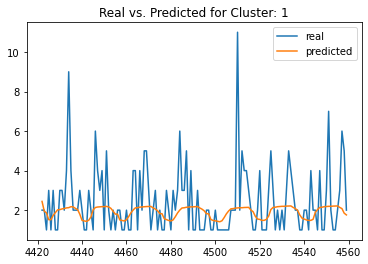

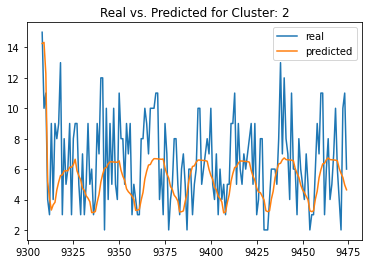

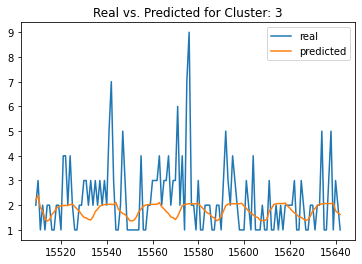

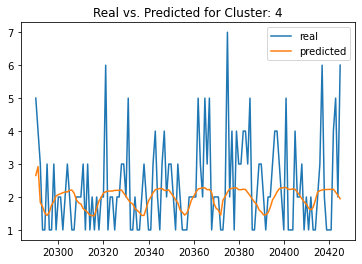

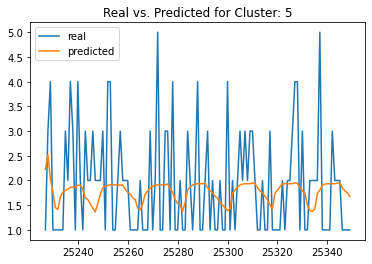

In [14]:
idx = X_val[(X_val['month'] == 1) & (X_val['day'].isin([1, 2, 3, 4, 5, 6, 7]))].index
df_val_plot = X_val.loc[idx, :].copy()
df_val_plot['Incident_Number'] = y_val[idx]

for clus in df_val_plot['Cluster'].unique():
  df_tmp = df_val_plot[df_val_plot['Cluster'] == clus]
  X_ = df_tmp.drop(['Incident_Number'], axis=1)
  y_ = reg.predict(X_)

  plt.plot(df_tmp.index, df_tmp['Incident_Number'], label='real')
  plt.plot(X_.index, y_, label='predicted')
  plt.title('Real vs. Predicted for Cluster: {}'.format(clus))
  plt.legend()
  plt.show()

It also seems like certain clusters have higher numbers of calls than others, indicating the importance of this feature

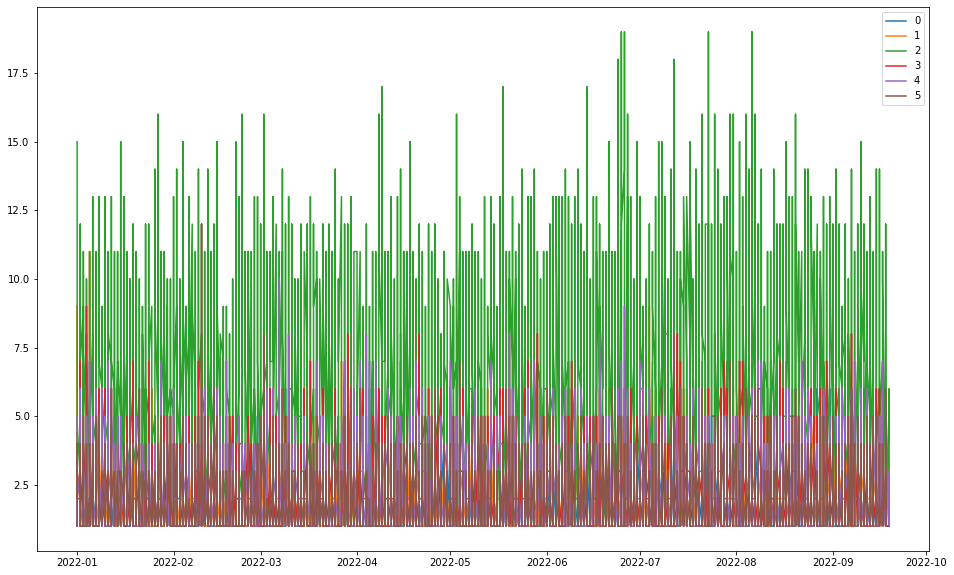

In [21]:
df_val_plot = X_val.copy()
df_val_plot['Incident_Number'] = y_val

plt.figure(figsize=(16, 10))
for cluster in df_val_plot['Cluster'].unique():
  df_tmp = df_val_plot[df_val_plot['Cluster'] == cluster]
  plt.plot(pd.to_datetime(df_tmp[['year', 'month', 'day']]), df_tmp['Incident_Number'], label=cluster)
plt.legend()
plt.show()

# Hyperparameter tuning

I tried to get this working, however I think that due to the data being time series this messed around with the cross validation. I attempted different methods including a time series split CV method, but didn't have any luck.

In [33]:
params = {
    'loss': ['squared_error', 'absolute_error'],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_iter': [40, 80, 100, 200]
}

reg = HistGradientBoostingRegressor()

grid_search = GridSearchCV(estimator = reg, scoring='neg_mean_absolute_error', param_grid=params, cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=HistGradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'loss': ['squared_error', 'absolute_error'],
                         'max_iter': [40, 80, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=3)

In [34]:
print(grid_search.best_params_)

{'learning_rate': 0.01, 'loss': 'absolute_error', 'max_iter': 40}


In [ ]:
reg = GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error', max_features='log2', n_estimators=40, subsample=0.6)
reg.fit(X_train, y_train)
print('Training R2: {}'.format(reg.score(X_train, y_train)))
print('Test R2: {}'.format(reg.score(X_test, y_test)))
print('Validation R2: {}'.format(reg.score(X_val, y_val)))

Training R2: 0.18145654583854343
Test R2: 0.11729650601112407
Validation R2: 0.02277129954936863


# Searching for optimal number of clusters

The optimal number was found to be 6

In [ ]:
clus_num = []
train_r2 = []
test_r2 = []
val_r2 = []

for i in range(1, 40):
  cluster_pipeline = Pipeline([
      ('scale', StandardScaler()),
      ('cluster', ReturnCluster(clusters=i))
  ])

  train_clusters = cluster_pipeline.fit_transform(df_train[['Longitude', 'Latitude']])
  test_clusters = cluster_pipeline.transform(df_test[['Longitude', 'Latitude']])
  val_clusters = cluster_pipeline.transform(df_val[['Longitude', 'Latitude']])

  X_train, y_train = prepare_data(df_train, train_clusters, False)
  X_test, y_test = prepare_data(df_test, test_clusters, False)
  X_val, y_val = prepare_data(df_val, val_clusters, False)

  reg = GradientBoostingRegressor()
  reg.fit(X_train, y_train)
  print('Clusters: {}'.format(i))
  print('Training R2: {}'.format(reg.score(X_train, y_train)))
  print('Test R2: {}'.format(reg.score(X_test, y_test)))
  print('Validation R2: {}'.format(reg.score(X_val, y_val)))
  clus_num.append(i)
  train_r2.append(reg.score(X_train, y_train))
  test_r2.append(reg.score(X_test, y_test))
  val_r2.append(reg.score(X_val, y_val))

Clusters: 1
Training R2: 0.16903333962329048
Test R2: -0.14889611285400117
Validation R2: -1.5074218167186522
Clusters: 2
Training R2: 0.8852664130723664
Test R2: 0.7990999950089483
Validation R2: 0.7059734949187184
Clusters: 3
Training R2: 0.8791412401381535
Test R2: 0.8064177210378161
Validation R2: 0.7399198249195414
Clusters: 4
Training R2: 0.899574904741211
Test R2: 0.8586712914820638
Validation R2: 0.8107926168969168
Clusters: 5
Training R2: 0.9253012436336409
Test R2: 0.8948501300193816
Validation R2: 0.8663273841115344
Clusters: 6
Training R2: 0.9336937174428437
Test R2: 0.9102217415760938
Validation R2: 0.8855740764102896
Clusters: 7
Training R2: 0.9012037476334867
Test R2: 0.855056106364686
Validation R2: 0.8336045438673348
Clusters: 8
Training R2: 0.9114462164393143
Test R2: 0.8761582512733337
Validation R2: 0.8563915859103015
Clusters: 9
Training R2: 0.8925763680036578
Test R2: 0.8609421614164909
Validation R2: 0.8406718917676799
Clusters: 10
Training R2: 0.8872199745167375

Plot of R2 on training, testing and validation sets for varying numbers of clusters

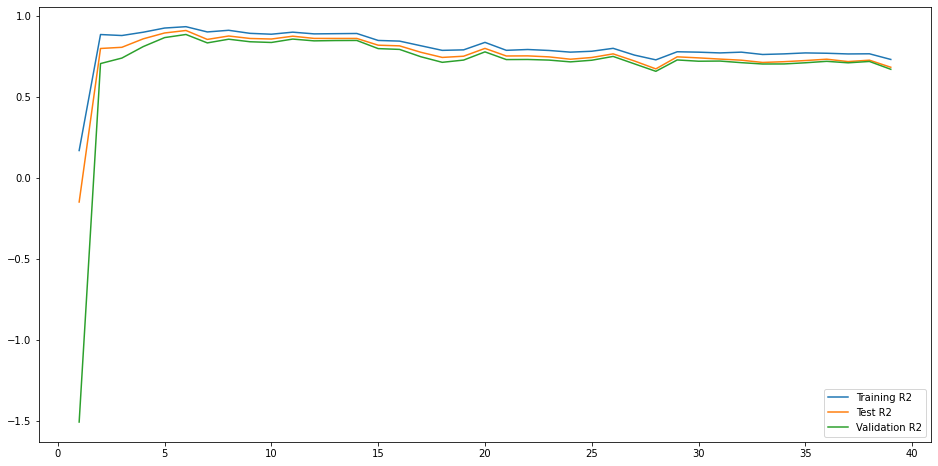

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(clus_num, train_r2, label='Training R2')
plt.plot(clus_num, test_r2, label='Test R2')
plt.plot(clus_num, val_r2, label='Validation R2')
plt.legend()
plt.show()

In [ ]:
print('Cluster for max validation R2: {}'.format(clus_num[val_r2.index(max(val_r2))]))
print('Cluster for max validation R2: {}'.format(clus_num[test_r2.index(max(test_r2))]))

Cluster for max validation R2: 6
Cluster for max validation R2: 6


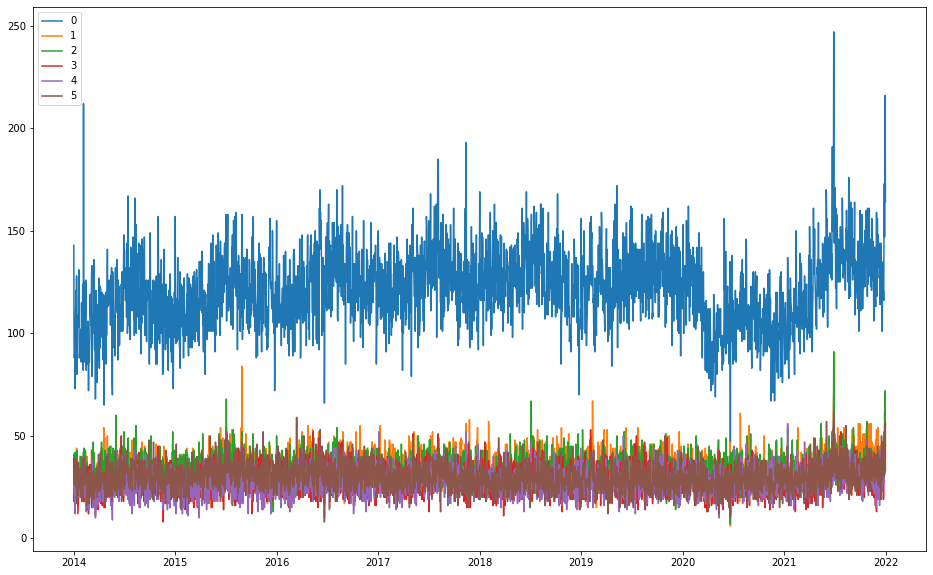

In [ ]:
plt.figure(figsize=(16, 10))
for cluster in df_agg_month['Cluster'].unique():
  df_tmp = df_agg_month[df_agg_month['Cluster'] == cluster]
  plt.plot(pd.to_datetime(df_tmp[['year', 'month', 'day']]), df_tmp['Incident_Number'], label=cluster)
plt.legend()
plt.show()

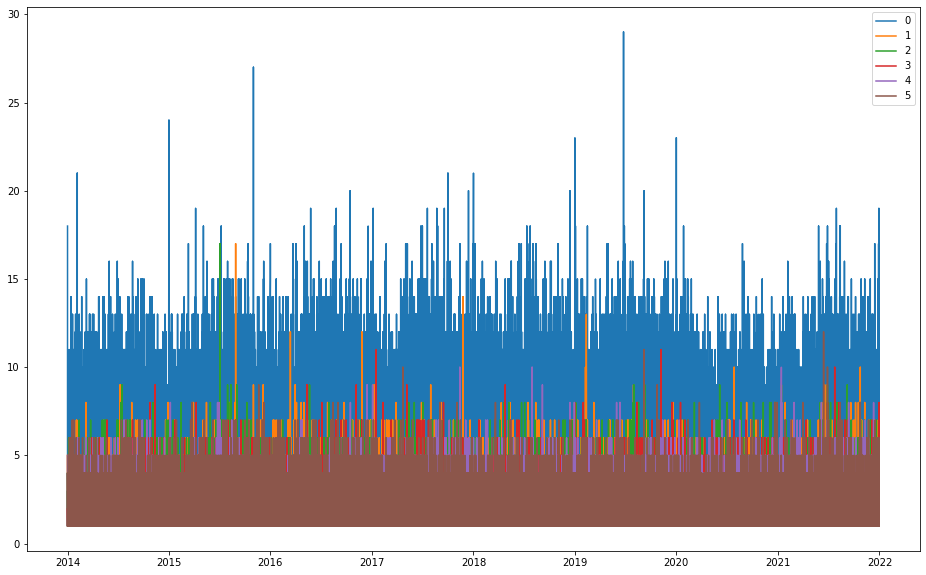

In [ ]:
plt.figure(figsize=(16, 10))
for cluster in df_agg_hour['Cluster'].unique():
  df_tmp = df_agg_hour[df_agg_hour['Cluster'] == cluster]
  plt.plot(pd.to_datetime(df_tmp[['year', 'month', 'day']]), df_tmp['Incident_Number'], label=cluster)
plt.legend()
plt.show()

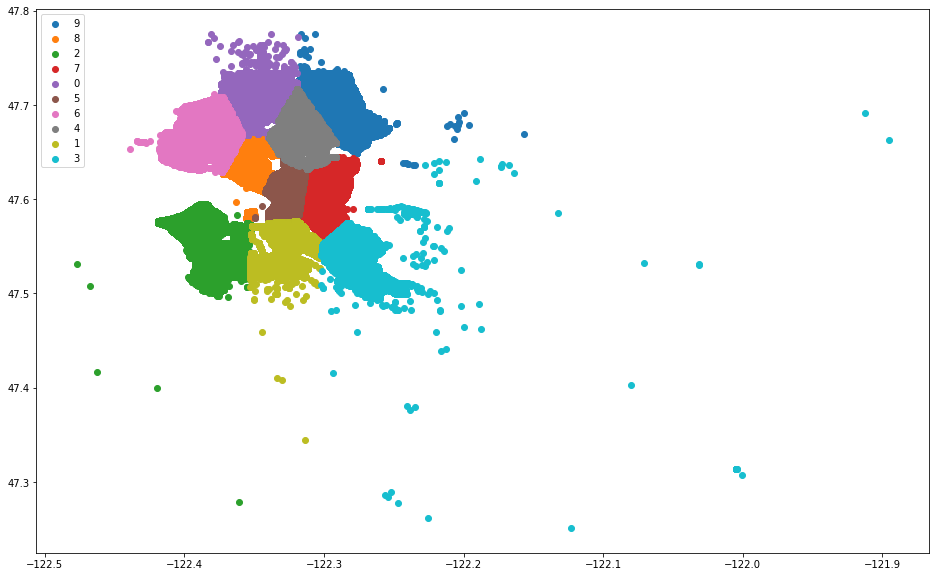

In [ ]:
plt.figure(figsize=(16, 10))
for cluster in df_train['Cluster'].unique():
  df_tmp = df_train[df_train['Cluster'] == cluster]
  plt.scatter(df_tmp['Longitude'], df_tmp['Latitude'], label=cluster)
plt.legend()
plt.show()

Training R2: 0.8872199745167375
Test R2: 0.857527433606104
Validation R2: 0.8362378481383035


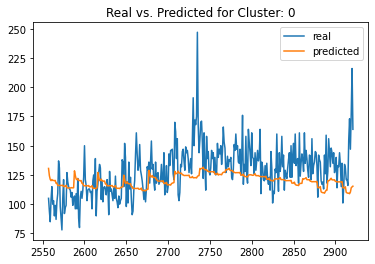

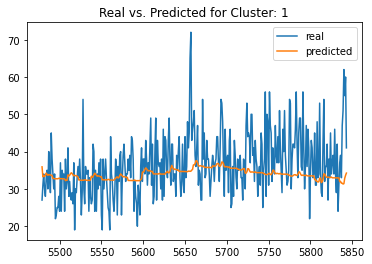

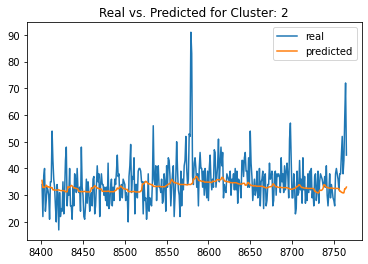

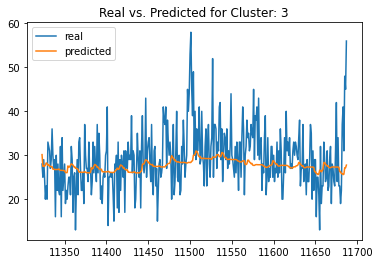

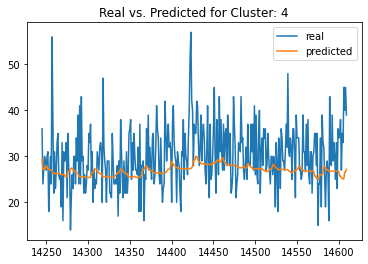

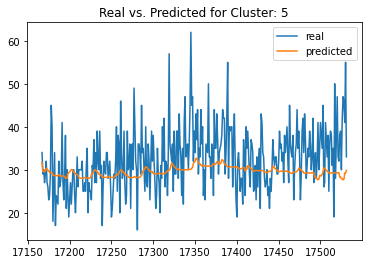